In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import seaborn as sns

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import Dense,Flatten,Concatenate

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau

from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2,EfficientNetB0,EfficientNetB4,Xception

import warnings
import glob
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# !pip install tensorflow-gpu==2.11.0

In [3]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
train = pd.read_csv("../input/rsna-bone-age/boneage-training-dataset.csv")
test = pd.read_csv("../input/rsna-bone-age/boneage-test-dataset.csv")

train['id'] = train['id'].astype(str)
test['Case ID'] = test['Case ID'].astype(str)

train['id'] = train['id']+'.png'
test['Case ID'] = test['Case ID']+'.png'

train['male'].replace({False : 0, True : 1}, inplace=True)

In [5]:
train.shape, test.shape

((12611, 3), (200, 2))

gender
male      6833
female    5778
Name: count, dtype: int64


<Axes: xlabel='gender', ylabel='count'>

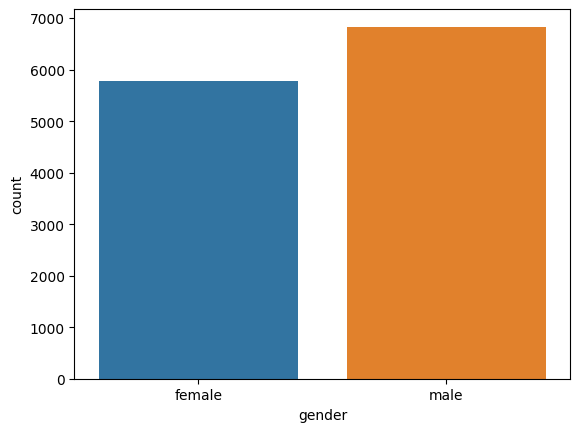

In [6]:
train['gender'] = train['male'].apply(lambda x: 'male' if x else 'female')
print(train['gender'].value_counts())
sns.countplot(x = train['gender'])

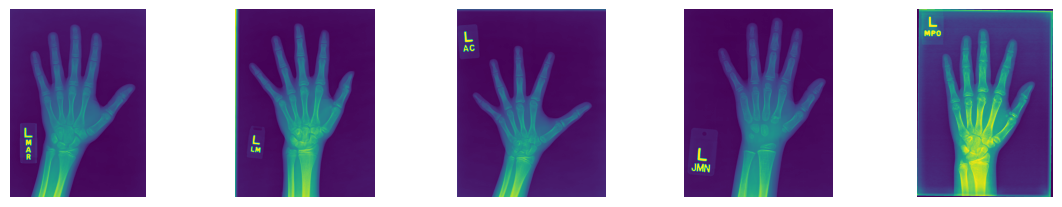

In [7]:
paths = glob.glob("../input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/*.png")
plt.figure(figsize=(20, 20))
for i in range(5):
    cur_img = mpimg.imread(paths[i]) 
    ax = plt.subplot(7, 7, i + 1)
    plt.imshow(cur_img)
    plt.axis("off")

# Image Preprocessing


## CLAHE -- An Algorithm to improve the contrast of images

### Case 1

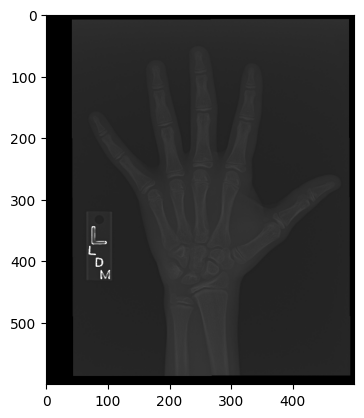

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Reading the image from the present directory
image = cv2.imread("/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/4233.png")
# Resizing the image for compatibility
image = cv2.resize(image, (500, 600))

# The initial processing of the image
# image = cv2.medianBlur(image, 3)
image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# The declaration of CLAHE
# clipLimit -> Threshold for contrast limiting
clahe = cv2.createCLAHE(clipLimit=4)
final_img = clahe.apply(image_bw)

# Ordinary thresholding the same image
_, ordinary_img = cv2.threshold(image_bw, 155, 255, cv2.THRESH_BINARY)
plt.imshow(image)


### Converted Image

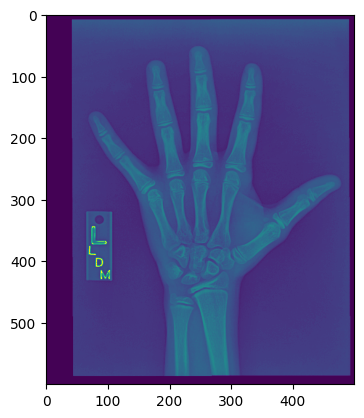

In [9]:
plt.imshow(final_img)


## Case 2

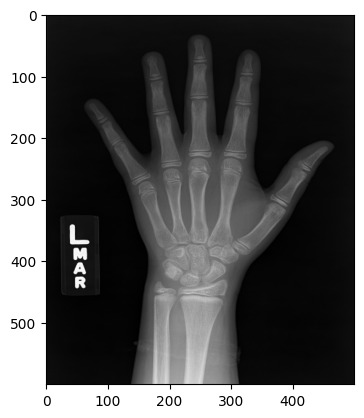

In [10]:
import cv2
import numpy as np

# Reading the image from the present directory
image = cv2.imread("/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset/7497.png")
# Resizing the image for compatibility
image = cv2.resize(image, (500, 600))

# The initial processing of the image
# image = cv2.medianBlur(image, 3)
image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# The declaration of CLAHE
# clipLimit -> Threshold for contrast limiting
clahe = cv2.createCLAHE(clipLimit=4)
final_img = clahe.apply(image_bw)

# Ordinary thresholding the same image
_, ordinary_img = cv2.threshold(image_bw, 155, 255, cv2.THRESH_BINARY)

# Showing the two images
plt.imshow(image)

## Converted Final image

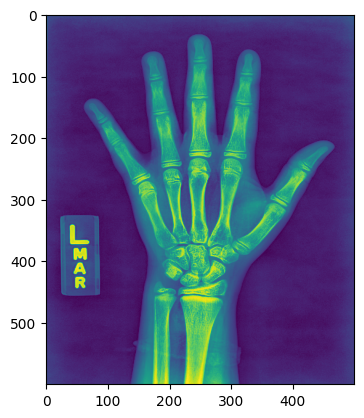

In [11]:
plt.imshow(final_img)


## Applying CLHE For Entire Dataset

In [12]:
import cv2
import os
from tqdm import tqdm  # Import tqdm for progress bar

def apply_clahe_and_threshold(input_path, output_path, clip_limit=5, threshold_value=155):
    with tf.device('/cpu:0'):

    # Create output directory if it doesn't exist
        os.makedirs(output_path, exist_ok=True)

        # List all image files in the input directory
        image_files = [f for f in os.listdir(input_path) if f.lower().endswith('.png')]

        for image_filename in tqdm(image_files, desc="Processing images"):  # tqdm for progress bar
            # Read image from file
            image = cv2.imread(os.path.join(input_path, image_filename))
            image = cv2.resize(image, (500, 600))

            # Convert to grayscale
            image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Apply CLAHE
            clahe = cv2.createCLAHE(clipLimit=clip_limit)
            final_img = clahe.apply(image_bw)

            # Ordinary thresholding
            _, ordinary_img = cv2.threshold(image_bw, threshold_value, 255, cv2.THRESH_BINARY)

            # Save transformed images
            cv2.imwrite(os.path.join(output_path, f"clahe_{image_filename}"), final_img)
    #         cv2.imwrite(os.path.join(output_path, f"threshold_{image_filename}"), ordinary_img)

# Define paths
input_dataset_path = '/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset'
output_dataset_path = '/kaggle/working/boneage-training-dataset'  
clip_limit = 20
threshold_value = 155
with tf.device('/cpu:0'):
    apply_clahe_and_threshold(input_dataset_path, output_dataset_path, clip_limit, threshold_value)


Processing images: 100%|██████████| 12611/12611 [10:53<00:00, 19.29it/s]


In [13]:
input_dataset_path = '/kaggle/input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset'
output_dataset_path = '/kaggle/working/boneage-test-dataset'  
clip_limit = 20
threshold_value = 155
with tf.device('/cpu:0'):
    apply_clahe_and_threshold(input_dataset_path, output_dataset_path, clip_limit, threshold_value)

Processing images: 100%|██████████| 200/200 [00:08<00:00, 22.45it/s]


In [14]:
train_images = []
train_target = []
train_gender = []

val_images = []
val_target = []
val_gender = []

In [15]:
for i in range(0, 7500):
    img = tf.keras.utils.load_img('/kaggle/working/boneage-training-dataset/'+"clahe_"+train['id'][i], grayscale=True, target_size=(256,256))
    train_images.append(np.asarray(img) /255.)
    train_target.append(train['boneage'][i])
    train_gender.append(train['male'][i])
    if(i % 1250 == 0):
        print(i, 'Image Train Loaded')
print('Train Image Loaded !!')

0 Image Train Loaded
1250 Image Train Loaded
2500 Image Train Loaded
3750 Image Train Loaded
5000 Image Train Loaded
6250 Image Train Loaded
Train Image Loaded !!


In [16]:
for i in range(7501, 7601):
    img = tf.keras.utils.load_img('/kaggle/working/boneage-training-dataset/'+"clahe_"+train['id'][i], grayscale=True, target_size=(256,256))
    val_images.append(np.asarray(img) /255.)
    val_target.append(train['boneage'][i])
    val_gender.append(train['male'][i])

print('\nValidation Image Loaded !!')


Validation Image Loaded !!


In [17]:
train_images = np.asarray(train_images)
train_target = np.asarray(train_target)
train_gender = np.asarray(train_gender)

val_images = np.asarray(val_images)
val_target = np.asarray(val_target)
val_gender = np.asarray(val_gender)

In [18]:
def build_model():
    # Image
    base = tf.keras.applications.EfficientNetB4(weights=None, include_top=False, input_tensor=Input(shape=(256, 256, 1)))
#     base = tf.keras.applications.vgg16.VGG16(weights=None, include_top=False, input_tensor=Input(shape=(256, 256, 1)))
    base.trainable = True
    
    flatten = base.output
    flatten = Flatten()(flatten)
    bboxHead = Dense(128, activation="relu")(flatten)
    bboxHead = Dense(64, activation="relu")(bboxHead)
    bboxHead = Dense(32, activation="relu")(bboxHead)
    image_model = Model(inputs=base.input, outputs=bboxHead)
    
    
    # Gender
    gender_input = Input(shape=(1,))
    y = Dense(64, activation="relu")(gender_input)
    y = Dense(32, activation="relu")(y)
    gender_model = Model(inputs=gender_input, outputs=y)
    
    # Coombain
    concatenate_layer = Concatenate()([image_model.output,gender_model.output])
    concatenate_layer = Dense(32, activation="relu")(concatenate_layer)
    concatenate_layer = Dense(16, activation="relu")(concatenate_layer)
    final = Dense(1, activation="linear")(concatenate_layer)

    model = Model(inputs=[image_model.input,gender_model.input], outputs=final)
    
    return model

In [19]:
model = build_model()

In [20]:
# !nvidia-smi
# !pip uninstall tensorflow-gpu==2.9.1

In [21]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
sch = tf.keras.callbacks.LearningRateScheduler(
    scheduler, verbose=1
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.001,verbose=1)

In [22]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0,patience=2,verbose=1,mode='auto',baseline=None,restore_best_weights=True)

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), loss='mae')

save_best = tf.keras.callbacks.ModelCheckpoint("Model.h5", monitor='val_loss',save_best_only=True, verbose=1)

In [24]:

model.fit(x=[train_images,train_gender], y=train_target, validation_split=0.2, epochs=35, callbacks=[save_best,early,reduce_lr,sch])


Epoch 1: LearningRateScheduler setting learning rate to 0.000699999975040555.
Epoch 1/35


2023-09-27 19:07:20.399166: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


188/188 [==============================] - ETA: 0s - loss: 38.5066
Epoch 1: val_loss improved from inf to 31.69322, saving model to Model.h5
188/188 [==============================] - 284s 973ms/step - loss: 38.5066 - val_loss: 31.6932 - lr: 7.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.000699999975040555.
Epoch 2/35
188/188 [==============================] - ETA: 0s - loss: 27.1803
Epoch 2: val_loss did not improve from 31.69322
188/188 [==============================] - 165s 879ms/step - loss: 27.1803 - val_loss: 33.2830 - lr: 7.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.000699999975040555.
Epoch 3/35
188/188 [==============================] - ETA: 0s - loss: 22.4742
Epoch 3: val_loss did not improve from 31.69322
188/188 [==============================] - 165s 877ms/step - loss: 22.4742 - val_loss: 46.2717 - lr: 7.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.000699999975040555.
Epoch 4/35
188/188 [==============

In [25]:
model = tf.keras.models.load_model('./Model.h5')

In [26]:
pred = model.predict([val_images,val_gender], verbose=1)

4/4 [==============================] - 4s 458ms/step


In [27]:
import sklearn.metrics as sm
print("Median absolute error =", round(sm.median_absolute_error(pred, val_target), 2)) 
print("R2 score =", round(sm.r2_score(pred, val_target), 2))

Median absolute error = 7.93
R2 score = 0.88


In [28]:
new=val_images[2].reshape(1,256,256)
new_gen = val_gender[2].reshape((1,))
type(new)

numpy.ndarray

In [29]:
# data_set = tf.data.Dataset.from_tensor_slices((val_images[0]))
# data_set_2 = tf.data.Dataset.from_tensor_slices((val_gender[0]))

In [30]:
pred_in = model.predict([new,new_gen] ,verbose=1)
print("predicted value: ",pred_in)
print("Actual value: ",val_target[2])

1/1 [==============================] - 1s 773ms/step
predicted value:  [[94.89266]]
Actual value:  106


In [31]:
def predict_individual_image(image_index:int):
    new=val_images[image_index].reshape(1,256,256)
    new_gen = val_gender[image_index].reshape((1,))
    pred_in = model.predict([new,new_gen] ,verbose=1)
    act = val_target[image_index]
    print("Predicted value: ",pred_in)
    print("Actual value: ",act)

predict_individual_image(15)

1/1 [==============================] - 0s 36ms/step
Predicted value:  [[174.70972]]
Actual value:  186


1/1 [==============================] - 0s 36ms/step


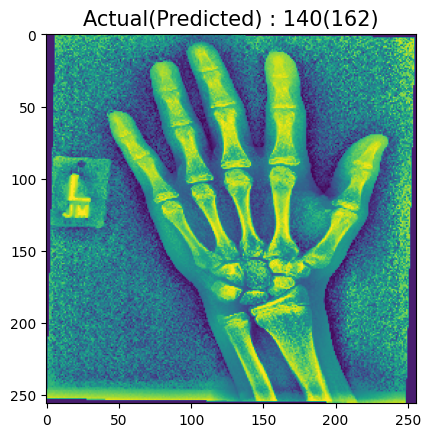

In [32]:
def plot_pred(image_index:int):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    new=val_images[image_index].reshape(1,256,256)
    new_gen = val_gender[image_index].reshape((1,))
    pred_in = model.predict([new,new_gen] ,verbose=1)
    act = val_target[image_index]
    ax.set_title('Actual(Predicted) : {}({})'.format(int(pred_in),act), fontsize=15)
    imgplot = plt.imshow(val_images[image_index])
    plt.show()
    
plot_pred(55)